# Bayesian Optimization Tutorial (Exercise): 1-dimensional Bayesian optimization using GP expected improvement acquisition function   
**By Wenjie Xu**

Throughout this exercise, you will see blocks of code. In some of the places, they contain an indicator:
```python
## [TODO]
```

This indicates the part of code that you need to implement yourself.  

### Introduction
For this tutorial, we will attempt to find the global minima of the Rastrigin function $$f(x)=10+x^2-10\cos(2\pi x)$$ in the domain $x \in [-5.12,5.12]$.

The two main components of Bayesian optimization are:
1. A surrogate model for approximating the black-box objective function $f(x)$.
2. An "acqusition function" $q(x)$ that informs us of the value in samping the new point $x$ for optimization purpose.


In [4]:
## Be sure to run this cell first to import the relied packages 

## Installing relevant packages by uncommenting the following line
# !pip install GPy scipy numpy matplotlib ipython

import GPy
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(40)

%matplotlib inline
%reload_ext autoreload
%autoreload 2


## Learning the black-box function $f(x)$ with a Gaussian Process

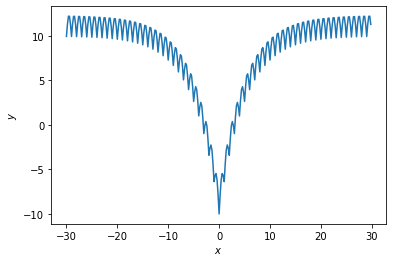

In [37]:
## Edit here.
y_shift = -10
noise_level = 1e-2
def f(x):
    """The function to be optimized."""
    # [TODO]: return the Rastrigin function value 
    return 

x_bound = (-5.12, 5.12)
## Stop editing here.

## Plot the function
fig = plt.figure()
ax = fig.gca()
x_step = 0.2
x_arr = np.arange(x_bound[0], x_bound[1], x_step)
y_arr = f(x_arr)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

plt.plot(x_arr, y_arr)
plt.show()

It is clear that the global minima is at around $x=0.0$, but there are lots of 'adversarial' minima distributed in the whole input domain. 

To learn the function with a Gaussian Process, we first choose its hyperparameters.

For the convenience of demonstration, we use the Squared Exponential (RBF) kernel as our covariance, and a zero mean. For the kernel, we manually set the lengthscale to be $2.0$, kernel variance as $5$ and noise standard deviation as $0.05$.


(-30.0, 30.0)

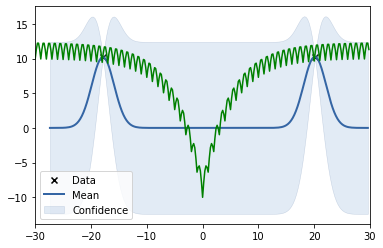

In [42]:
## [TODO]: select the proper hyperparameters 
length_scale = 2.0
sigma_noise = 5e-2
prior_mean = 0.0
fun_var = 40.0
num_random_init = 2

# Set the kernel for the Gaussian process
kernel = GPy.kern.RBF(input_dim=1, 
                      variance=fun_var,
                      lengthscale=length_scale,
                      ARD=True
                     )

# pick several randomly sampled points to initialize the GP
init_X = x_bound[0] + np.random.rand(num_random_init) * (x_bound[1] - x_bound[0]) 
init_Y = f(init_X)

np.int = np.int32
obj_gp = GPy.models.GPRegression(
    np.expand_dims(init_X, axis=1),
    np.expand_dims(init_Y, axis=1),
    kernel,
    noise_var = sigma_noise ** 2
)

fig, ax = plt.subplots() 

obj_gp.plot(ax=ax)

ax.plot(x_arr, y_arr, color='g')
ax.set_xlim(x_bound)

Optimizing GP hyperparameters by fitting to the data.

(-30.0, 30.0)

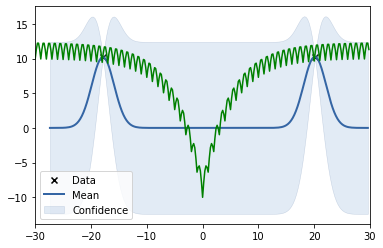

In [43]:
# obj_gp.optimize()  # optimize the hyperparameters 
fig, ax = plt.subplots() 

obj_gp.plot(ax=ax)

ax.plot(x_arr, y_arr, color='g')
ax.set_xlim(x_bound)

## The Acquisition Function

### Expected Improvement $q_\text{EI}$

A popular acquisition function is the expected improvement. This measures the expectation of the function improvement as compared to the current best value.

\begin{equation}
q_\text{EI}(x) = \mathbb{E}(\max(f_t^\text{min}-f(x), 0)|\mathcal{D}_t), 
\end{equation}
where $f_t^\text{min}$ is the minimum objective function value observed so far, and $\mathcal{D}_t$ is the historical function evaluation dataset.  

As shown in the existing literature, we have,
\begin{equation}
q_\text{EI}(x) = (f_t^\text{min}-\mu_t(x))\Phi(z)+\sigma_t(x)\phi(z), 
\end{equation}
where 
\begin{equation}
z=\frac{f_t^\text{min}-\mu_t(x)}{\sigma_t(x)}, 
\end{equation}
$\Phi(\cdot)$ and $\phi(\cdot)$ are the standard normal cumulative distribution and probability density functions, respectively.

In [5]:
def qEI(gp, x, fmin):
    # [TODO] implement the EI acquisition function here 
    return 

bigM = 30
lcb = qEI(obj_gp, np.expand_dims(x_arr, axis=1), bigM)


fig, ax = plt.subplots() 

obj_gp.plot(ax=ax)

ax.plot(x_arr, y_arr, color='g')
ax.plot(x_arr, lcb, color='r')
ax.set_xlim(x_bound)


NameError: name 'obj_gp' is not defined

# Run Bayesian Optimization in a closed loop

In [6]:
run_num = 5

# define the function that optimizes the acquisition function
def get_next_point(gp, x_arr, fmin):
    qEI_arr = qEI(gp, x_arr, fmin)
    qEI_arr = np.squeeze(qEI_arr)
    next_point_id = np.argmax(qEI_arr)
    return x_arr[next_point_id]

## Do the iterate.

In [7]:
simple_regret_list = []  # track the evolution of simple regret, which is defined as the minimum objective value sampled so far minus the ground truth optimal value
ground_truth_min_val = np.min(y_arr)

for i in range(4):
    fmin = np.min(obj_gp.Y)
    next_point = get_next_point(obj_gp, np.expand_dims(x_arr, axis=1), fmin) # get the next point 
    print(f'New sample point: {next_point}.')
    new_f_val = f(next_point) 
    
    new_X = np.concatenate((obj_gp.X, np.atleast_2d(next_point)))
    new_Y = np.concatenate((obj_gp.Y, np.atleast_2d(new_f_val)))
    obj_gp.set_XY(new_X, new_Y)
    
    best_val = np.min(new_Y)
    simple_regret = best_val - ground_truth_min_val
    simple_regret_list.append(simple_regret)
    
    # plot the new result
    EI_arr = qEI(obj_gp, np.expand_dims(x_arr, axis=1))
    fig, ax = plt.subplots() 

    obj_gp.plot(ax=ax)
    ax.plot(x_arr, y_arr, color='g')
    ax.plot(x_arr, EI_arr, color='r')
    ax.set_xlim(x_bound)

    

NameError: name 'y_arr' is not defined

## Plot the evolution of simple regret

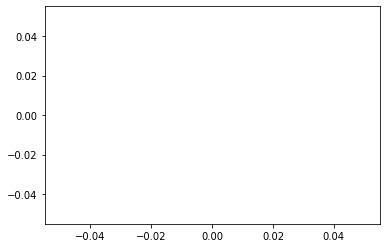

In [8]:
plt.plot(simple_regret_list)